<a href="https://colab.research.google.com/github/kristian1108/YT8M/blob/master/YT8M_Third_Video_Understanding_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
#**Candidate Generation For Large-Scale Facial Recognition In Videos**
---
Abstract: 

Drawing inspiration from recent advancements in video labeling and recommender systems, this project aims to develop a multi-staged approach to large-scale facial recognition in videos. In pursuit of this, models were developed and tested to understand context from videos, which in turn can be used to narrow down the likely set of faces appearing therein. In doing so, this model architecture could be useful in improving the effectiveness and efficiency of facial recognition software. The data used to develop these models came from the YouTube-8M and CelebA datasets. In order to support the ability to iterate and experiment quickly, a wrapper class for the YouTube-8M dataset was developed and shared publicly for others to use in their own research. The results of this project indicate promise for the concepts being tested, but further development is required to bring it to full fruition. 


---

Prepared for Advanced Machine Learning Final Project by:

Kristian Gaylord (krg2136), Daniel Rogoff (dr2635), Yaxin Deng (yd2467), Min Sun (ms5709)


---


##**Setup**

In [0]:
#!pip install --upgrade tensorflow# ~~ This, and the following install statements, should be uncommented and run if first time setting up.
#!pip install face_recognition
#!pip install opencv-python-headless
#!pip install pafy
#!pip install -U youtube-dl

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
from IPython.display import YouTubeVideo
import urllib.request as ur
from collections import Counter
import datetime
from google.colab import files
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import dlib
import cv2
import pafy
import youtube_dl
from google.colab.patches import cv2_imshow
import face_recognition
import face_recognition_models

## **The ``` YouTubeInput``` class is a wrapper class that grants easy access to decoded and formatted data from the TFRecord files that come from the YT8M dataset.**


In [0]:
class YouTubeInput:

  """
  @param filepath: file pattern of the files you want to import, in gfile.glob format.
  @param vocab_path: the filepath to the vocab document. 
  @param top_n_labels: how many of the top n labels you would like to look at. 

  returns None
  """
  def __init__(self, filepath, vocab_path, top_n_labels=100):
    self.filepath = filepath
    self.raw_data = tf.data.TFRecordDataset(tf.io.gfile.glob(self.filepath))
    self.vocab_path = vocab_path

    self.video_ids = []
    self.labels = []

    self.fill_labels_ids()

    self.vocab = pd.read_csv(self.vocab_path)
    self.label_to_name = self.vocab[['Index', 'Name']].set_index('Index', drop=True).to_dict()['Name']
    self.vertical_dict = self.vocab[['Index', 'Vertical1']].set_index('Index', drop=True).to_dict()['Vertical1']
        
    self.unique_verticals = self.vocab['Vertical1'].unique()
    self.vertical_depth = len(self.unique_verticals)

    self.vertical_to_int = {}
    self.int_to_vertical = {}
        
    self.fill_vertical_dicts()
        
    self.label_depth = len(self.vocab['Index'].unique())
        
    self.top_labels = []
    self.top_n_labels(top_n_labels)

    self.label_to_code = {}
    self.code_to_label = {}

    self.create_code_label_maps()

    self.trimmed_labels = []
    self.null_lists = []
    self.no_blank_labels = []

    self.trim_empty_labels()

    self.encoded_labels = [tuple(self.label_encode(l)) for l in self.no_blank_labels]
        
    self.use_verticals = False
    self.one_hot = False
    self.use_set = False
    self.recurrent_reshape = False
    self.recurrent_lab_reshape = False
    self.take_first = False
    self.normal_mean_var = False
    self.frames = 300
    self.batch_size = 10

  def fill_vertical_dicts(self):
    for i in range(len(self.unique_verticals)):
      self.vertical_to_int[self.unique_verticals[i]] = i
      self.int_to_vertical[i] = self.unique_verticals[i]
            
    for key, value in self.vertical_dict.items():
      self.vertical_dict[key] = self.vertical_to_int[value]
            
    self.to_vertical1 = tf.lookup.KeyValueTensorInitializer(keys=list(self.vertical_dict.keys()), 
                                                 values=list(self.vertical_dict.values()))
    self.vertical1_table = tf.lookup.StaticHashTable(self.to_vertical1, -1)

  def trim_empty_labels(self):
    for label in self.labels:
      x = [l for l in label if l in self.top_labels]
      self.trimmed_labels.append(x)

    self.null_lists = [i for i in range(len(self.trimmed_labels)) if self.trimmed_labels[i] == []]

    for i in range(len(self.video_ids)):
      if i not in self.null_lists:
        self.no_blank_labels.append(self.trimmed_labels[i])

  def create_code_label_maps(self):
    self.label_to_code = {}
    self.code_to_label = {}

    for i in range(len(self.top_labels)):

        self.label_to_code[self.top_labels[i]] = i
        self.code_to_label[i] = self.top_labels[i]

  def top_n_labels(self, inp=100):
    n = inp
    top_n = Counter([item for sublist in self.labels for item in sublist]).most_common(n)
    top_n_labels = [int(i[0]) for i in top_n]

    self.top_labels = top_n_labels

    return top_n_labels

  def fill_labels_ids(self):
    for record in self.raw_data.take(-1):
      example = tf.train.Example()
      example.ParseFromString(record.numpy())

      id_value = tf.compat.as_str_any(example.features.feature['id'].bytes_list.value[0])
      self.video_ids.append(id_value)
      self.labels.append(example.features.feature['labels'].int64_list.value)

  def parse_input(self, record):
    context = {'id': tf.io.FixedLenFeature([], tf.string, default_value=''),
               'labels': tf.io.VarLenFeature(tf.int64)}

    feat = {'audio': tf.io.FixedLenSequenceFeature([], tf.string),
            'rgb': tf.io.FixedLenSequenceFeature([], tf.string)}

    parsed_features = tf.io.parse_single_sequence_example(serialized=record, context_features=context, sequence_features=feat)

    context = parsed_features[0]
    features = parsed_features[1]

    context['labels'] = tf.cast(context['labels'].values, tf.int32)

    features['audio'] = tf.cast(tf.io.decode_raw(features['audio'], tf.uint8), tf.float32)
    features['rgb'] = tf.cast(tf.io.decode_raw(features['rgb'], tf.uint8), tf.float32)

    final_feat = tf.concat([features['rgb'], features['audio']], -1)
        
    if self.use_verticals:
        labels = self.vertical1_table.lookup(context['labels'])
    else: 
        labels = context['labels']

    if self.use_set: 
        labels, idx = tf.unique(labels)
            
    if self.take_first:    
        labels = tf.slice(labels, [0],[1])
            
    if self.one_hot:
        labels = tf.reduce_sum(tf.one_hot(labels, depth=len(self.unique_verticals)), 0)
            
    if self.recurrent_reshape:      
        rows = tf.shape(final_feat)[0]
        cols = tf.shape(final_feat)[1]
            
        zero_rows = self.frames-rows
            
        zes = tf.zeros(shape=(zero_rows, 1152))
            
        if zero_rows > 0: 
            final_feat = tf.concat([final_feat, zes], 0)
                
        final_feat = tf.reshape(final_feat,(self.frames,1152))
                        
    if self.recurrent_lab_reshape: 
        labels = tf.tile(labels, [self.frames, 1]) 
        
    mean, variance = tf.nn.moments(final_feat, axes=[0])
    final_norm = ((final_feat - mean) / tf.sqrt(variance))
               
    if self.normal_mean_var:
        return final_norm, labels
        
    return final_feat, labels

  def get_raw(self):
    return self.raw_data

  """
  @param use_verticals: if True, converts individual labels to the corresponding primary vertical. 
  @param one_hot: if True, converts labels to one-hot vector (or multi-hot if multiple labels)
  @param use_set: if True, deletes duplicate labels if any exist. 
  @param recurrent_reshape: if True, reshapes input tensor to be compatible with recurrent network (*note, you must also use batch afterward) 
  @param recurrent_lab_reshape: if True, reshapes label tensor to be compatible with recurrent network (*note, must use same batch size as features)
  @param take_first: if True, only keeps the first label if there are multiple.
  @param normal_mean_var: if True, scales feature data to have mean 0 and variance 1. 
  @param frames: number of default frames to standardize across samples. 
  @batch_size: size of batches in the dataset. 

  returns MapDataset for ingestion into Keras model. 
  """
  def get_mapped(self, use_verticals=False, one_hot=False, use_set=False, recurrent_reshape=False, 
                  recurrent_lab_reshape=False, take_first=False, normal_mean_var=False, frames=300, batch_size=100):
    if use_verticals: 
      self.use_verticals=True    
    if one_hot: 
      self.one_hot = True
    if use_set:
      self.use_set = True
    if recurrent_reshape: 
      self.recurrent_reshape = True
    if recurrent_lab_reshape: 
      self.recurrent_lab_reshape = True
    if take_first:
      self.take_first = True
    if normal_mean_var:
      self.normal_mean_var = True
            
    self.frames=frames
    self.batch_size = batch_size
            
    return (self.raw_data.map(self.parse_input)).batch(batch_size)
    
  def get_labels(self):
      return self.labels

  def get_ids(self):
      return self.video_ids

  def label_decode(self, label):
      return [self.code_to_label[l] for l in label]

  def label_encode(self, label):
      return [self.label_to_code[l] for l in label]


  def get_video_id(self, index=0):
    vid_id = self.video_ids[index]
    pre = vid_id[:2]
    link = 'http://data.yt8m.org/2/j/i/' + str(pre) + '/' + str(vid_id) + '.js'
    file = ur.urlopen(link)
    data = tf.compat.as_str_any(file.read())
    file.close()
    data = data.split(',')
    real_id = data[1].replace(';','').replace(')','').replace('"','')
    return real_id
        

## **Code snippets showing some examples of the YouTubeInput Class:**

In [0]:
train = YouTubeInput('train0255.tfrecord', 'vocab.csv')
validate = YouTubeInput('validate0143.tfrecord', 'vocab.csv')

**All options are false, raw data.**

In [0]:
train_dataset = train.get_mapped(use_verticals=False, one_hot=False, use_set=False, 
                     recurrent_reshape=False, recurrent_lab_reshape=False, 
                     take_first=False, normal_mean_var=False, frames=300, batch_size=1)

for element in train_dataset.take(2):
  print(element[0])
  print(element[1])

tf.Tensor(
[[[  0. 190.  50. ... 217.  54. 219.]
  [154.  97.  37. ... 154.  75. 255.]
  [138.  71.  37. ... 246. 123. 175.]
  ...
  [  0. 149.  43. ... 148.  44. 255.]
  [  0. 148.  42. ...  74.  40. 252.]
  [  0. 148.  42. ... 139.  41. 132.]]], shape=(1, 217, 1152), dtype=float32)
tf.Tensor([[0]], shape=(1, 1), dtype=int32)
tf.Tensor(
[[[119.  97. 102. ... 193. 132.   0.]
  [168. 175.  94. ... 255.  45.  54.]
  [152. 175.  86. ... 159. 137.  83.]
  ...
  [177. 132.  81. ... 166. 157.  86.]
  [159. 140. 111. ...  89. 118.  54.]
  [167. 148.  89. ... 255. 120.   0.]]], shape=(1, 181, 1152), dtype=float32)
tf.Tensor([[ 53  58 163 232]], shape=(1, 4), dtype=int32)


**One-hot encoded, verticals, reshaped for recurrent net.**

Rreshaping for the recurrent network duplicates and reshapes the label to ensure that there is one label for each timestep (rows) in the feature tensor.

In [0]:
train_dataset = train.get_mapped(use_verticals=True, one_hot=True, use_set=True, 
                     recurrent_reshape=True, recurrent_lab_reshape=True, 
                     take_first=True, normal_mean_var=False, frames=300, batch_size=1)

for element in train_dataset.take(2):
  print(element[0])
  print(element[1])

tf.Tensor(
[[[  0. 190.  50. ... 217.  54. 219.]
  [154.  97.  37. ... 154.  75. 255.]
  [138.  71.  37. ... 246. 123. 175.]
  ...
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]], shape=(1, 300, 1152), dtype=float32)
tf.Tensor(
[[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]], shape=(1, 300, 25), dtype=float32)
tf.Tensor(
[[[119.  97. 102. ... 193. 132.   0.]
  [168. 175.  94. ... 255.  45.  54.]
  [152. 175.  86. ... 159. 137.  83.]
  ...
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]], shape=(1, 300, 1152), dtype=float32)
tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]], shape=(1, 300, 25), dtype=float32)


##**Exploring the YT8M data a bit...**

In [0]:
print("There are {} unique labels in the dataset".format(train.label_depth))

There are 3862 unique labels in the dataset


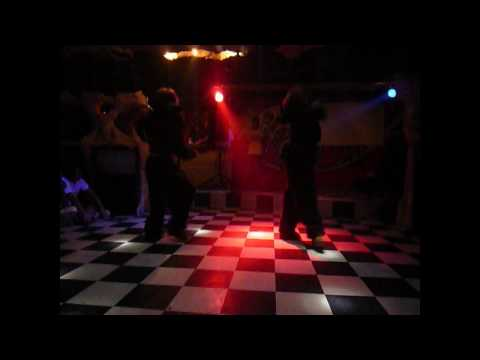

In [0]:
#You can change vid_id to see what videos are in this particular train file. 
vid_id = 13

YouTubeVideo(train.get_video_id(vid_id))

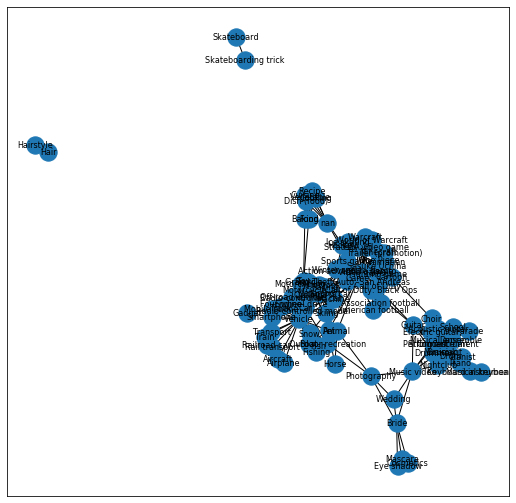

In [0]:
"""
This graph code was inspired by data exploration done in the 3rd Video Understanding
Challenge on Kaggle. https://www.kaggle.com/c/youtube8m-2019

It was modified to fit into the YouTubeInput Framework.

The generated graph shows how labels are connected to one another by way of being 
applicable to the same videos. 
"""
G = nx.Graph()

G.clear()

for list_of_nodes in train.labels:
  filtered_nodes = set(list_of_nodes).intersection(set(train.top_labels) & set(train.vocab['Index'].unique()))  
  
  for node1,node2 in list(combinations(filtered_nodes,2)): 
    node1_name = train.label_to_name[node1]
    node2_name = train.label_to_name[node2]
    G.add_node(node1_name)
    G.add_node(node2_name)
    G.add_edge(node1_name, node2_name)

plt.figure(figsize=(9,9))
nx.draw_networkx(G, font_size="8")

##**Video Understanding Models**

**No real training was done in this Colab Notebook due to the lack of adequate persistent storage (the YT8M files were about 100GB). This tensorboard cell is just symbolic.**

In [0]:
%load_ext tensorboard
!rm -rf logs/ 

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

**Due to the size of the classification space, we observed that the neural network had a tendency to converge on setting all of the values to zero. This practiced returned a relatively high accuracy value (due to the fact that the one-hot vector is mostly zeros), but was obviously suboptimal for the purpose of this project. To mitigate this behavior, we deployed a custom ```WeightedBinaryCrossEntropy``` loss function that assigns extra weight for positively labeled values.**

 

In [0]:
"""
This custom WeightedBinaryCrossEntropy loss class was inspired by code from 
TensorFlow: https://www.tensorflow.org/guide/keras/train_and_evaluate. 
"""
class WeightedBinaryCrossEntropy(keras.losses.Loss):
  
  def __init__(self, pos_weight, weight, from_logits=False, 
               reduction=keras.losses.Reduction.AUTO,
               name='weighted_binary_crossentropy'):
     super(WeightedBinaryCrossEntropy, self).__init__(reduction=reduction,
                                                         name=name)
     self.pos_weight = pos_weight
     self.weight = weight
     self.from_logits = from_logits

  def call(self, y_true, y_pred):
    if not self.from_logits:
      x_1 = y_true * self.pos_weight * -tf.math.log(y_pred + 1e-6)
      x_2 = (1 - y_true) * -tf.math.log(1 - y_pred + 1e-6)
      return tf.add(x_1, x_2) * self.weight 

    return tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, self.pos_weight) * self.weight

**Model 1: Simple Feed-Forward Network**

Notes: The learning rate in this network is quite high. This was found to be most effective after many empirical tests. The optimizer is also SGD; we went back and forth between SGD, Adam, and RMSprop, but finally settled on SGD because none of the others seemed to do anything too different. The final activation is sigmoid to support multi-label classification. We also experimented with exponential decay learning rate, but decided to take it out in this final version because it didn't seem to help. Finally, it's worth noting that we don't do any special transformation to the frame features in this model — rather we just pass them through an initial input layer as one group and then flatten them into a giant fully connected layer early on. 



In [0]:
from tensorflow.keras import models, layers

model = models.Sequential()

model.add(layers.Dense(512, activation='relu', input_shape=(train.frames,1152), use_bias=True))
model.add(layers.Flatten())

model.add(layers.Dense(300, activation='softmax'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(300, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, activation='relu', use_bias=True))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, activation='softmax'))
model.add(layers.Dense(100, activation='relu', use_bias=True))

model.add(layers.Dense(train.vertical_depth, activation='sigmoid'))

opt = tf.optimizers.SGD(learning_rate=0.1)
met = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
los = WeightedBinaryCrossEntropy(pos_weight=2, weight=0.1, from_logits=True)

model.compile(optimizer=opt, loss=los, metrics=[met])
model.summary()

#model.fit(train_dataset, epochs=20, verbose=1, validation_data=validation_dataset, callbacks=[tensorboard_callback])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 300, 512)          590336    
_________________________________________________________________
flatten_3 (Flatten)          (None, 153600)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 300)               46080300  
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_10 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)              

This model won't be trained here in Colab due to a lack of persistent data storate, but here is a screenshot from Tensorboard of its train run:

![Tensorboard Screenshot]('Screen Shot 2019-12-16 at 11.40.02 AM.png')

**Model 2: Stacked Recurrent Neural Network**

Notes: In order for this code to work, the data must be retrieved with the `recurrent_reshape` parameter set to `True` in the `YouTubeInput.get_mapped()` function. The `recurrent_lab_reshape` should remain set to `False` because this particular recurrent network is predicting final labels, not labels at each step. The final version of this network was arrived at through a lot of empirical examination. The activation functions are all softmax or sigmoid because relu activations within the LSTM cell caused the loss to diverge. The Dropout layers seemed to improve convergence time. The final fully connected layer has a sigmoid activation to allow for the multi-label scenario. In contrast to the model above, which just smashes all of the frame data together in one go, this model looks at a single frame at a time as it tries to predict the label. The LSTM recurrent network takes data in the shape of (batch_size, number of time steps, hidden size); in this case, the number of time steps perfectly matches up with the rows of the feature matrix, which in turn represent individual frames from the videos. This seems like a more natural way to model the videos, and the empirical evidence suggests this model works as well, if not better than the strictly feed-forward net. It does take longer to train though. 


In [0]:
model = models.Sequential()

model.add(layers.LSTM(128, return_sequences=True, activation='softmax'))
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(564, return_sequences=True, activation='sigmoid'))
model.add(layers.LSTM(258, return_sequences=True, activation='softmax'))
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(128, return_sequences=True, activation='sigmoid'))
model.add(layers.LSTM(24, return_sequences=True, activation='softmax'))
model.add(layers.TimeDistributed(layers.Dense(1000)))

model.add(layers.Dense(512, activation='relu', use_bias=True))
model.add(layers.Flatten())
model.add(layers.Dense(300, activation='softmax', use_bias=True))
model.add(layers.Dense(train.vertical_depth, activation='sigmoid'))

model.build(input_shape=(train.batch_size,train.frames,1152))
model.compile(optimizer=opt, loss=los, metrics=[met])
model.summary()

#model.fit(train_dataset, epochs=20, verbose=1, validation_data=validation_dataset, callbacks=[tensorboard_callback])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               multiple                  655872    
_________________________________________________________________
dropout_22 (Dropout)         multiple                  0         
_________________________________________________________________
lstm_26 (LSTM)               multiple                  1563408   
_________________________________________________________________
lstm_27 (LSTM)               multiple                  849336    
_________________________________________________________________
dropout_23 (Dropout)         multiple                  0         
_________________________________________________________________
lstm_28 (LSTM)               multiple                  198144    
_________________________________________________________________
lstm_29 (LSTM)               multiple                 

Similar to above, this model won't be trained here, but a screenshot of the Tensorboard result can be found here: ![Recurrent Network](Recurrent Network.png)

##**Face Detection & Identification**

In [0]:
videos = YouTubeInput('*.tfrecord')

video_ids = videos.video_ids
labels = videos.labels

Identifying faces from a large list of possible faces generated a large number of misclassification errors. However, narrowing the scope to one face and a number of videos that, contextually, are likely to contain that face would produce better results in principle. In this case, we limited our scope to comedy videos and sought to identify famous comedians. As the code below illustrates, there are 71 such videos in this sample of YouTube videos.

In [0]:
indices = []
for j in range(len(labels)):
  for i in labels[j]:
    ##label for "comedians" is 325
    if i==325: 
      indices.append(j)

71

In [0]:
def get_video_id(index=0):
    vid_id = video_ids[index]
    pre = vid_id[:2]
    link = 'http://data.yt8m.org/2/j/i/' + str(pre) + '/' + str(vid_id) + '.js'
    file = ur.urlopen(link)
    data = tf.compat.as_str_any(file.read())
    file.close()
    data = data.split(',')
    real_id = data[1].replace(';','').replace(')','').replace('"','')
    return real_id

**Face Detection**

To detect faces, we incorporate the Face_Recognition library with OpenCV's video reading functionality. Face_Recognition uses dlib's get_frontal_face_detector() function. This function utilizes Dalal and Triggs' [Histogram of Oriented Gradients](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) technique to identify the faces. 

The function here yields a 99.4% accuracy against the Faces In The Wild benchmark. In the 100 YouTube videos that we manually sampled to confirm its applicability to this context, we found 0 false positives. Conversely, we did not check for false negatives, since we're already sampling around 180 frames per video and are not concerned with the possibility that a frame only occurs in a small number of frames of the video.

In [0]:
def generate_sample_frame_faces(input_movie,length):
# Initialize variables
  face_encodings_output = []
  faces_output = []
  face_locations = []
  face_encodings = []
  face_names = []
  frame_number = 0

  # We're limiting ourselves to the first 2000 frames of video - roughly the first 2 minutes - since these operations are computationally expesnive 
  while frame_number<=min(3000,length):
      # Get one frame of video
      ret, frame = input_movie.read()
      frame_number += 1
      


    # Flip rgb to bgr, and sample 1/25th of frames - ie one for every second of video
      if frame_number%25 == 0:
        rgb_frame = frame[:, :, ::-1]

      # Find all the faces and face encodings in the current frame of video
        face_locations = face_recognition.face_locations(rgb_frame, model="cnn")
        face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

    #print(face_recognition.face_locations(rgb_frame, model="cnn"))

        if face_locations and face_locations[0][2]-face_locations[0][0] > 60 and face_locations[0][1]-face_locations[0][3] > 60:
          face_encodings_output.append(face_recognition.face_encodings(rgb_frame, face_locations))
          


  # All done!
  input_movie.release()
  return face_encodings_output

Here we upload Dane Cook faces. As noted above, when we try to match faces from many celebrities, the large number of possible faces induces misclassification errors. Narrowing our scope to binary classification of a single celebrity's face, however, produced better results.

The faces themselves are taken from the CelebA dataset, with the specific mapping of these pictures to Dane Cook provided by the stewards of CelebA.

In [0]:
dane_cook_faces = []
img = face_recognition.load_image_file('gdrive/My Drive/DaneCook/0'+str(11200)+'.jpg')
dane_cook_faces.append(face_recognition.face_encodings(img))
img = face_recognition.load_image_file('gdrive/My Drive/DaneCook/0'+str(13494)+'.jpg')
dane_cook_faces.append(face_recognition.face_encodings(img))
img = face_recognition.load_image_file('gdrive/My Drive/DaneCook/0'+str(13611)+'.jpg')
dane_cook_faces.append(face_recognition.face_encodings(img))
img = face_recognition.load_image_file('gdrive/My Drive/DaneCook/0'+str(15137)+'.jpg')
dane_cook_faces.append(face_recognition.face_encodings(img))
img = face_recognition.load_image_file('gdrive/My Drive/DaneCook/0'+str(17623)+'.jpg')
dane_cook_faces.append(face_recognition.face_encodings(img))
img = face_recognition.load_image_file('gdrive/My Drive/DaneCook/0'+str(19937)+'.jpg')
dane_cook_faces.append(face_recognition.face_encodings(img))
img = face_recognition.load_image_file('gdrive/My Drive/DaneCook/0'+str(28121)+'.jpg')
dane_cook_faces.append(face_recognition.face_encodings(img))
img = face_recognition.load_image_file('gdrive/My Drive/DaneCook/0'+str(29918)+'.jpg')
dane_cook_faces.append(face_recognition.face_encodings(img))



  

**Face Identification**

To identify faces, we again incorporate the Face_Recognition library with OpenCV's video reading functionality. Face_Recognition uses [Open Faces](https://cmusatyalab.github.io/openface/)'s published [networks](https://github.com/cmusatyalab/openface/tree/master/models/openface) to encode faces into a 128-d embedding space; following that, it uses a simple SVM to determine whether two faces are a match. 

In [0]:
def match_faces(known_faces,face_encodings_output,t):
  # Initialize variables
  results = []
  matches = []
  # For each face in our list of known faces...
  for j in range(len(known_faces)):
    # ... and for each face in the faces we've taken from the video...
    for i in range(len(face_encodings_output)):
      # ... check if they're a match
      if face_recognition.compare_faces(known_faces[j], face_encodings_output[i][0], tolerance=t)==[True]:
        match = j
        matches.append(match)
  # return the matches
  results.append(matches)
  return results

This is where it all comes together: for a given set of videos (defined above in terms of a particular label, in this case comedy videos) we a) load the video b) extract the faces and c) determine if they match Dane Cook. Unfortunately, we weren't able to achieve good results in this step.

In [0]:
### Matches by video
matches = []
j=0
for i in indices[21:50]:
  try:
    url = "https://www.youtube.com/watch?v="+get_video_id(i)
    print(url)
    urlPafy = pafy.new(url)
    videoplay = urlPafy.getbest()

    input_movie = cv2.VideoCapture(url)

    length = int(input_movie.get(cv2.CAP_PROP_FRAME_COUNT))

    face_encodings_output = generate_sample_frame_faces(input_movie,length)

    matches_in_video = match_faces(dane_cook_faces,face_encodings_output,.3)
    matches.append(matches_in_video)

    print("Done with "+str(j+1)+", "+str(len(matches_in_video[0]))+" matches in video")
    input_movie.release()
  except:
    print("Error of some sort for "+str(j+1)+", skipping")
  j=j+1
